In [ ]:
!pip install timm

In [ ]:
!pip install torchsummary

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
# from einops import rearrange, reduce, repeat
# from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [2]:
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [8]:
vit_b_16 = models.vit_b_16(pretrained=True)

In [9]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.functional.InterpolationMode('bicubic')),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [3]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

In [4]:
def test_img(img_path,vit):
    img = Image.open(img_path)
    fig = plt.figure()
    plt.imshow(img)
    vit.eval()
    config = resolve_data_config({}, model=vit)
    print(config)
    test_transform = create_transform(**config)
    img = test_transform(img)[None,]
    output = vit(img)
    # print(output.shape)
    # print('sum of output',torch.sum(output,dim=-1))
    # print(output)
    idx = torch.argmax(output).item()
    print('idx is',idx)
    print('test result class is ',idx2label[idx])

test result class is  Egyptian cat


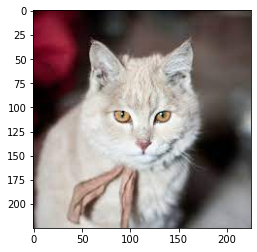

In [72]:
test_img('images/cat.jpg',vit_b_16)

In [5]:
import timm
from timm.models import vision_transformer
from timm.models.vision_transformer import Attention
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from types import MethodType
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [6]:
def attention_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

    # attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = self.matmul1(q, k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)
    attn = self.attn_drop(attn)
    del q, k

    # x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.matmul2(attn, v).transpose(1, 2).reshape(B, N, C)
    del attn, v
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

In [7]:
class MatMul(nn.Module):
    def forward(self, A, B):
        return A @ B

{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.9}
idx is 1
test result class is  goldfish, Carassius auratus


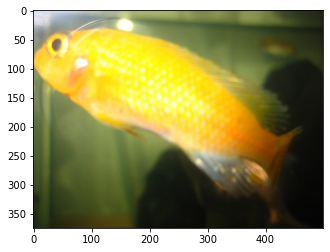

In [9]:
net = timm.create_model('vit_base_patch16_224', pretrained=True)
test_img('data/imagenet/val/n01443537/ILSVRC2012_val_00003150.JPEG',net)

In [10]:
net = timm.create_model('vit_base_patch16_224', pretrained=True)
for name,module in net.named_modules():
    if isinstance(module, Attention):
        setattr(module, "matmul1", MatMul())
        setattr(module, "matmul2", MatMul())
        module.forward = MethodType(attention_forward, module)
net.cuda()
net.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (matmul1): MatMul()
        (matmul2): MatMul()
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      

In [11]:
def wrap_modules_in_net(net,cfg):
    wrapped_modules={}
    module_dict={}
    module_types = {"qkv":"qlinear_qkv", "proj":'qlinear_proj', 'fc1':'qlinear_MLP_1', 'fc2':"qlinear_MLP_2", 'head':'qlinear_classifier','matmul1':"qmatmul_qk", 'matmul2':"qmatmul_scorev", "reduction": "qlinear_reduction"}
    
    it=[(name,m) for name,m in net.named_modules()]
    for name,m in it:
        module_dict[name]=m
        idx=name.rfind('.')
        if idx==-1:
            idx=0
        father_name=name[:idx]
        if father_name in module_dict:
            father_module=module_dict[father_name]
        else:
            raise RuntimeError(f"father module {father_name} not found")
        if isinstance(m,nn.Conv2d):
            # Embedding Layer
            idx = idx+1 if idx != 0 else idx
            new_m=cfg.get_module("qconv",m.in_channels,m.out_channels,m.kernel_size,m.stride,m.padding,m.dilation,m.groups,m.bias is not None,m.padding_mode)
            new_m.weight.data=m.weight.data
            new_m.bias=m.bias
            replace_m=new_m
            wrapped_modules[name] = new_m
            setattr(father_module,name[idx:],replace_m)
        elif isinstance(m,nn.Linear):
            # Linear Layer
            idx = idx+1 if idx != 0 else idx
            new_m = cfg.get_module(module_types[name[idx:]],m.in_features,m.out_features)
            new_m.weight.data=m.weight.data
            new_m.bias=m.bias
            replace_m=new_m
            wrapped_modules[name] = new_m
            setattr(father_module,name[idx:],replace_m)
        elif isinstance(m,MatMul):
            # Matmul Layer
            idx = idx+1 if idx != 0 else idx
            new_m = cfg.get_module(module_types[name[idx:]])
            replace_m=new_m
            wrapped_modules[name] = new_m
            setattr(father_module,name[idx:],replace_m)
    print("Completed net wrap.")
    return wrapped_modules

In [12]:
import os
from importlib import reload,import_module
import datasets
from tqdm import tqdm
from quant_calib import HessianQuantCalibrator

In [13]:
def init_config(config_name):
    """initialize the config. Use reload to make sure it's fresh one!"""
    _,_,files =  next(os.walk("./configs"))
    if config_name+".py" in files:
        quant_cfg = import_module(f"configs.{config_name}")
    else:
        raise NotImplementedError(f"Invalid config name {config_name}")
    reload(quant_cfg)
    return quant_cfg

In [14]:
def test_classification(net,test_loader,max_iteration=None, description=None):
    pos=0
    tot=0
    i = 0
    max_iteration = len(test_loader) if max_iteration is None else max_iteration
    with torch.no_grad():
        q=tqdm(test_loader, desc=description)
        for inp,target in q:
            i+=1
            inp=inp.cuda()
            target=target.cuda()
            out=net(inp)
            pos_num=torch.sum(out.argmax(1)==target).item()
            pos+=pos_num
            tot+=inp.size(0)
            q.set_postfix({"acc":pos/tot})
            if i >= max_iteration:
                break
    print(pos/tot)
    return pos/tot

In [15]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [16]:
print_model_size(net)

346.33 MB


In [17]:
quant_cfg = init_config("PTQ4ViT")
# quant_cfg = init_config("BasePTQ")
wrapped_modules = wrap_modules_in_net(net,quant_cfg)

g=datasets.ViTImageNetLoaderGenerator('./data/imagenet','imagenet',32,32,4,kwargs={"model":net})


Completed net wrap.


In [18]:
test_loader=g.test_loader()
calib_loader=g.calib_loader(num=32)
# test_classification(net,test_loader)

In [19]:
quant_calibrator = HessianQuantCalibrator(net,wrapped_modules,calib_loader,sequential=False,batch_size=4) # 16 is too big for ViT-L-16
quant_calibrator.batching_quant_calib()

prepare parallel calibration for ['patch_embed.proj', 'blocks.0.attn.qkv', 'blocks.0.attn.proj', 'blocks.0.attn.matmul1', 'blocks.0.attn.matmul2', 'blocks.0.mlp.fc1', 'blocks.0.mlp.fc2', 'blocks.1.attn.qkv', 'blocks.1.attn.proj', 'blocks.1.attn.matmul1', 'blocks.1.attn.matmul2', 'blocks.1.mlp.fc1', 'blocks.1.mlp.fc2', 'blocks.2.attn.qkv', 'blocks.2.attn.proj', 'blocks.2.attn.matmul1', 'blocks.2.attn.matmul2', 'blocks.2.mlp.fc1', 'blocks.2.mlp.fc2', 'blocks.3.attn.qkv', 'blocks.3.attn.proj', 'blocks.3.attn.matmul1', 'blocks.3.attn.matmul2', 'blocks.3.mlp.fc1', 'blocks.3.mlp.fc2', 'blocks.4.attn.qkv', 'blocks.4.attn.proj', 'blocks.4.attn.matmul1', 'blocks.4.attn.matmul2', 'blocks.4.mlp.fc1', 'blocks.4.mlp.fc2', 'blocks.5.attn.qkv', 'blocks.5.attn.proj', 'blocks.5.attn.matmul1', 'blocks.5.attn.matmul2', 'blocks.5.mlp.fc1', 'blocks.5.mlp.fc2', 'blocks.6.attn.qkv', 'blocks.6.attn.proj', 'blocks.6.attn.matmul1', 'blocks.6.attn.matmul2', 'blocks.6.mlp.fc1', 'blocks.6.mlp.fc2', 'blocks.7.attn.

Hessian:   0%|                                                                            | 0/74 [00:00<?, ?it/s, patch_embed.proj]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Hessian: 100%|███████████████████████████████████████████████████████████████████████████████| 74/74 [01:43<00:00,  1.40s/it, head]

hessian calibration finished


In [20]:
print_model_size(net)

346.33 MB


In [21]:
#PTQ4ViT
test_classification(net,test_loader)

100%|███████████████████████████████████████████████████████████████████████████████▉| 1562/1563 [02:36<00:00,  9.98it/s, acc=0.84]

0.8404


0.8404

In [69]:
#BasePTQ
test_classification(net,test_loader)

100%|█████████████████████████████████████████████████████▉| 1562/1563 [02:14<00:00, 11.62it/s, acc=0.839]

0.83876


0.83876

In [56]:
for name,m in net.named_parameters():
    print(name)
    print(m)

cls_token
Parameter containing:
tensor([[[ 3.2389e-01,  1.4362e-02, -4.3632e-01, -2.9668e-02,  4.9954e-01,
           3.4431e-01,  6.9270e-02,  1.5145e-02,  1.5875e-01,  6.6091e-03,
           2.9595e-02,  2.6433e-02,  4.8807e-02,  1.5438e-01,  7.6776e-02,
          -5.6193e-02,  2.3481e+00, -3.7596e-02, -7.9648e-02, -3.2865e-02,
           4.0753e-02,  1.0625e-01,  1.2637e-02,  1.2623e-01, -5.1822e-03,
          -2.3552e-01,  3.1639e-02,  6.2501e-02,  3.5712e-02, -1.7925e-02,
          -2.7995e-02,  8.2622e-01,  5.4036e-02,  3.6365e-02,  4.2601e-02,
           9.5680e-02, -4.4193e-02,  5.1107e-02,  1.9187e-01,  3.5678e-01,
           6.6560e-02,  8.5484e-03,  2.0514e-02,  2.7039e-02,  6.3104e-02,
           2.8506e-02, -9.6596e-02,  9.6870e-03,  1.0163e-01,  1.4900e-01,
           1.1239e-01,  3.5970e-02,  9.4504e-02,  3.3720e-02,  5.9837e-02,
          -5.9888e-01,  9.4817e-02, -5.0430e-02,  3.4835e-02,  2.4602e-02,
          -4.2094e-02,  4.2754e-02,  2.5239e-02, -1.9448e-02,  1.561

In [61]:
for name,m in net.named_modules():
    if isinstance(m,nn.Linear):
        print(name)
        print(m)

blocks.0.attn.qkv
PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True)
blocks.0.attn.proj
PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True)
blocks.0.mlp.fc1
PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True)
blocks.0.mlp.fc2
PostGeluPTQSLBatchingQuantLinear(in_features=3072, out_features=768, bias=True)
blocks.1.attn.qkv
PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True)
blocks.1.attn.proj
PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True)
blocks.1.mlp.fc1
PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True)
blocks.1.mlp.fc2
PostGeluPTQSLBatchingQuantLinear(in_features=3072, out_features=768, bias=True)
blocks.2.attn.qkv
PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True)
blocks.2.attn.proj
PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True)
blocks.2.mlp.fc1
PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True)

In [62]:
#PTQ4ViT
net

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): ChannelwiseBatchingQuantConv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (matmul1): PTQSLBatchingQuantMatMul()
        (matmul2): SoSPTQSLBatchingQuantMatMul()
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
     

In [70]:
#BasePTQ
net

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): BatchingEasyQuantConv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (matmul1): PTQSLBatchingQuantMatMul()
        (matmul2): PTQSLBatchingQuantMatMul()
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): 

In [44]:
g=datasets.ViTImageNetLoaderGenerator('./data/imagenet','imagenet',32,32,4,kwargs={"model":net})

In [22]:
from integer import get_model_int_weight

In [ ]:
get_model_int_weight(wrapped_modules)

In [26]:
get_model_int_weight(wrapped_modules)

{}

In [45]:
test_loader=g.test_loader()
# calib_loader=g.calib_loader(num=32)
test_classification(net,test_loader)

100%|█████████████████████████████████████████████████████▉| 1562/1563 [02:14<00:00, 11.62it/s, acc=0.845]

0.84528


0.84528

In [48]:
for name,m in net.named_parameters():
    print(name)
    print(m)

cls_token
Parameter containing:
tensor([[[ 3.2389e-01,  1.4362e-02, -4.3632e-01, -2.9668e-02,  4.9954e-01,
           3.4431e-01,  6.9270e-02,  1.5145e-02,  1.5875e-01,  6.6091e-03,
           2.9595e-02,  2.6433e-02,  4.8807e-02,  1.5438e-01,  7.6776e-02,
          -5.6193e-02,  2.3481e+00, -3.7596e-02, -7.9648e-02, -3.2865e-02,
           4.0753e-02,  1.0625e-01,  1.2637e-02,  1.2623e-01, -5.1822e-03,
          -2.3552e-01,  3.1639e-02,  6.2501e-02,  3.5712e-02, -1.7925e-02,
          -2.7995e-02,  8.2622e-01,  5.4036e-02,  3.6365e-02,  4.2601e-02,
           9.5680e-02, -4.4193e-02,  5.1107e-02,  1.9187e-01,  3.5678e-01,
           6.6560e-02,  8.5484e-03,  2.0514e-02,  2.7039e-02,  6.3104e-02,
           2.8506e-02, -9.6596e-02,  9.6870e-03,  1.0163e-01,  1.4900e-01,
           1.1239e-01,  3.5970e-02,  9.4504e-02,  3.3720e-02,  5.9837e-02,
          -5.9888e-01,  9.4817e-02, -5.0430e-02,  3.4835e-02,  2.4602e-02,
          -4.2094e-02,  4.2754e-02,  2.5239e-02, -1.9448e-02,  1.561

In [29]:
# model = timm.create_model("vit_base_patch16_224",pretrained=True)
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()
backend = "fbgemm"
model.qconfig = torch.quantization.get_default_qconfig(backend)
quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear,torch.nn.Conv2d}, dtype=torch.qint8)

Using cache found in /home/xz2727/.cache/torch/hub/facebookresearch_deit_main


In [30]:
print_model_size(quantized_model)

89.25 MB


In [33]:
def test_classification(net,test_loader,max_iteration=None, description=None):
    pos=0
    tot=0
    i = 0
    max_iteration = len(test_loader) if max_iteration is None else max_iteration
    with torch.no_grad():
        q=tqdm(test_loader, desc=description)
        for inp,target in q:
            i+=1
#             inp=inp
#             target=target
            inp=inp.cuda()
            target=target.cuda()
            out=net(inp)
            pos_num=torch.sum(out.argmax(1)==target).item()
            pos+=pos_num
            tot+=inp.size(0)
            q.set_postfix({"acc":pos/tot})
            if i >= max_iteration:
                break
    print(pos/tot)
    return pos/tot

In [32]:
# Dynamic Quantization in pytorch
g=datasets.ViTImageNetLoaderGenerator('./data/imagenet','imagenet',32,32,4,kwargs={"model":quantized_model})
test_loader=g.test_loader()
test_classification(quantized_model,test_loader)

100%|██████████████████████████████████████████████████████████████████████████████▉| 1562/1563 [33:15<00:01,  1.28s/it, acc=0.804]

0.80356


0.80356